In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import read_geolife
import tracers as tr
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import seaborn as sns
import os

In [13]:
root_path = "/mnt/d/maart18maxDist500noDROPv2"
perturbed_traces = []

space_noise, time_min_period = 10.0, 30 
traces = []
# Load and perturb traces user by user
for i in range(70):
    user_path = f'taxi_{i}'
    file_path = os.path.join(root_path, user_path)
    user_traces = []
    
    if os.path.exists(file_path):
        for file in os.scandir(file_path): 
            df = pd.read_csv(file, sep=",")
            
            # Convert timestamp to epoch, drop invalid timestamps
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
            df = df.dropna(subset=["Timestamp"])
            
            # Sort by time
            df = df.sort_values(by='Timestamp')

            trace = df[['Longitude', 'Latitude', 'Timestamp']].to_numpy()
            trace = [(x[0], x[1], int(x[2])) for x in trace]
            
            user_traces.append(trace)
    else:
        print("path not found")
    if user_traces:
        perturbed_user_traces = tr.perturb_traces((space_noise, time_min_period), user_traces, picker_str='closest')
        perturbed_traces.extend(perturbed_user_traces)
        traces.extend(user_traces)

print(f"Total perturbed traces: {len(perturbed_traces)}")


path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
path not found
Total perturbed traces: 6518


In [14]:
lat_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9028, 12.4965)) * 10000
lon_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9029, 12.4964)) * 10000
print("50 meter lat is: ", 10/lat_meter_per_degree, "°")
print("50 meter lon is: ", 10/lon_meter_per_degree, "°")
meter_per_degree = (lat_meter_per_degree + lon_meter_per_degree)/2
print(meter_per_degree)
print(10/meter_per_degree)

50 meter lat is:  9.039443250896991e-05 °
50 meter lon is:  9.199689221384284e-05 °
109662.80313373724
9.118862288979323e-05


In [15]:
from scipy import stats
import osmnx as ox
lat_noise = []
lon_noise = []
angles = []
noise_distr = []
prev_pert_lat = 0
prev_pert_lon = 0 
wgs84_to_utm = Transformer.from_crs(4326, 3065, always_xy=True)

for trace_idx in range(len(traces)):
    prev_pert_lon, prev_pert_lat = None, None
    current_lat, current_lon = None, None 
    
    for point_idx in range(len(traces[trace_idx])):
        perturbed_traces_lon, perturbed_traces_lat = perturbed_traces[trace_idx][point_idx][0], perturbed_traces[trace_idx][point_idx][1]
        traces_lon, traces_lat = traces[trace_idx][point_idx][0], traces[trace_idx][point_idx][1]

        noise = ox.distance.great_circle(perturbed_traces_lat, perturbed_traces_lon, traces_lat, traces_lon, earth_radius=6371009)
        noise_distr.append(noise/meter_per_degree)


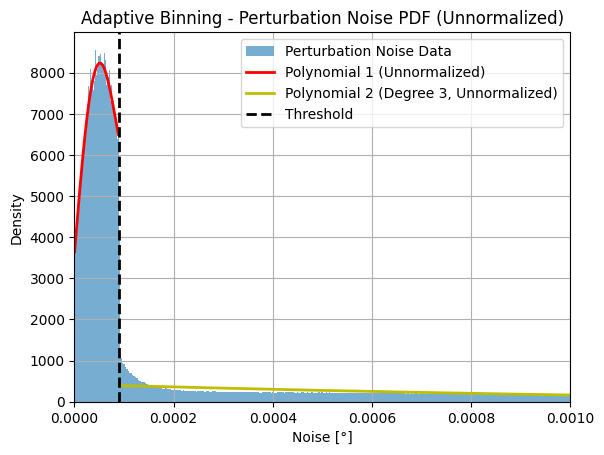

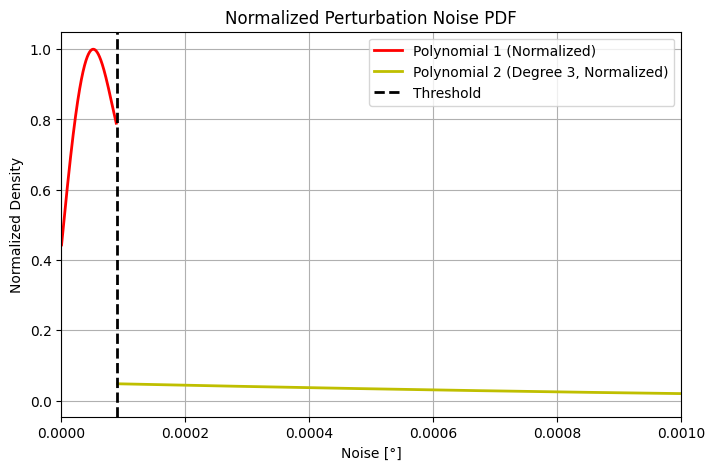

Polynomial 1 (Unnormalized):
           4             3             2
1.986e+20 x - 3.263e+16 x + 3.235e+10 x + 1.481e+08 x + 3581
Polynomial 2 (Degree 3, Unnormalized):
           2
6.925e+07 x - 3.291e+05 x + 422.5
Polynomial 1 (Normalized):
           4             3             2
2.413e+16 x - 3.963e+12 x + 3.929e+06 x + 1.799e+04 x + 0.4349
Polynomial 2 (Normalized):
      2
8411 x - 39.98 x + 0.05132


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define threshold for finer binning
threshold = 0.00009

num_fine_bins = 100  # More bins in the fine region
num_coarse_bins = 1000  # Fewer bins in the coarse region

fine_bins = np.linspace(0, threshold, num_fine_bins, endpoint=False)  # Small steps
coarse_bins = np.linspace(threshold, 0.003, num_coarse_bins)  # Larger steps

# Combine bin edges (remove duplicate threshold value)
bin_edges = np.concatenate((fine_bins, coarse_bins[1:]))

# Generate histogram with custom bins
hist_values, _ = np.histogram(noise_distr, bins=bin_edges, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

# Find boundary index
idx_boundary = np.searchsorted(bin_centers, threshold)

# Define x and y for fitting
x1, y1 = bin_centers[:idx_boundary], hist_values[:idx_boundary]
x2, y2 = bin_centers[idx_boundary:], hist_values[idx_boundary:]

# Fit polynomial for the first region
deg1 = 4
coeffs_1 = np.polyfit(x1, y1, deg1)
f_1 = np.poly1d(coeffs_1)

deg2 = 2 
coeffs_2 = np.polyfit(x2, y2, deg2)
f_2 = np.poly1d(coeffs_2)

# Smooth values for plotting
x_smooth_1 = np.linspace(min(x1), max(x1), 500) if f_1 else []
y_smooth_1 = f_1(x_smooth_1) if f_1 else []

x_smooth_2 = np.linspace(min(x2), max(x2), 500) if f_2 else []
y_smooth_2 = f_2(x_smooth_2) if f_2 else []

# Plot histogram with non-normalized polynomials
plt.hist(noise_distr, bins=bin_edges, density=True, label="Perturbation Noise Data", alpha=0.6)

# Plot non-normalized polynomials for both regions
if f_1:
    plt.plot(x_smooth_1, y_smooth_1, 'r-', linewidth=2, label="Polynomial 1 (Unnormalized)")
if f_2:
    plt.plot(x_smooth_2, y_smooth_2, 'y-', linewidth=2, label="Polynomial 2 (Degree 3, Unnormalized)")

plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Noise [°]")
plt.ylabel("Density")
plt.title("Adaptive Binning - Perturbation Noise PDF (Unnormalized)")
plt.legend()
plt.xlim(0, 0.001)
plt.grid(True)
plt.show()

# Normalize both polynomials by dividing by the maximum of the first polynomial
max_val = np.max(y_smooth_1)

if f_1:
    y_smooth_1 /= max_val

if f_2:
    y_smooth_2 /= max_val

# Plot normalized polynomials on a separate plot
plt.figure(figsize=(8, 5))

# Plot normalized polynomials for both regions
if f_1:
    plt.plot(x_smooth_1, y_smooth_1, 'r-', linewidth=2, label="Polynomial 1 (Normalized)")
if f_2:
    plt.plot(x_smooth_2, y_smooth_2, 'y-', linewidth=2, label="Polynomial 2 (Degree 3, Normalized)")

plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Noise [°]")
plt.ylabel("Normalized Density")
plt.title("Normalized Perturbation Noise PDF")
plt.legend()
plt.xlim(0, 0.001)
plt.grid(True)
plt.show()

# Print polynomial functions
if f_1:
    print("Polynomial 1 (Unnormalized):")
    print(f_1)

if f_2:
    print("Polynomial 2 (Degree 3, Unnormalized):")
    print(f_2)

# Output normalized polynomials
if f_1:
    print("Polynomial 1 (Normalized):")
    print(f_1 / max_val)

if f_2:
    print("Polynomial 2 (Normalized):")
    print(f_2 / max_val)


In [ ]:
# Compute histogram values
hist_values, bin_edges = np.histogram(noise_distr, bins=30000, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

# Filter out values above 0.005
mask = bin_centers <= 0.005  # Boolean mask to filter values
bin_centers_filtered = bin_centers[mask]
hist_values_filtered = hist_values[mask]

# Fit a polynomial (degree 6, can be adjusted)
poly_coeffs = np.polyfit(bin_centers_filtered, hist_values_filtered, deg=6)
poly_fit = np.poly1d(poly_coeffs)

# Generate smooth x values for plotting
x_smooth = np.linspace(0, 0.0005, 10000)
y_smooth = poly_fit(x_smooth)

# Plot histogram and polynomial fit
plt.hist(noise_distr, bins=500, density=True, alpha=0.5, label="Histogram")
plt.plot(x_smooth, y_smooth, label="Polynomial Fit (deg=6)", color='red', linewidth=2)
plt.legend()
plt.xlabel("Noise Values")
plt.xlim(0, 0.005)
plt.ylabel("Density")
plt.title("Histogram with Polynomial Fit (Filtered)")

plt.show()

### Noise angle

In [ ]:
angles_deg = np.degrees(angles)

# Violin plot to show distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lat_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Latitude Noise (meters)")
plt.title("Latitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lon_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Longitude Noise (meters)")
plt.title("Longitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()


In [ ]:
#angle range
angle_min = -30
angle_max = 0

selected_indices = (angles_deg >= angle_min) & (angles_deg < angle_max)
selected_lon_noise = np.array(lon_noise)[selected_indices]
selected_lat_noise = np.array(lat_noise)[selected_indices]

plt.hist(selected_lat_noise, bins=100)
plt.xlabel("Latitute Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Latitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()

plt.hist(selected_lon_noise, bins=100)
plt.xlabel("Longitude Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Longitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()
